## 볼린저 밴드 테스트

In [1]:
import numpy as np
import pandas as pd
import FinanceDataReader as fdr
from tqdm import tqdm
from marcap import marcap_data

### 생존자 편항 제거를 위해, 폐지된 종목까지 포함된 데이터 가져옴

In [2]:
%time df = marcap_data('2010-01-01', '2018-12-31')

CPU times: user 18 s, sys: 2.15 s, total: 20.2 s
Wall time: 20.5 s


#### 종목코드

In [3]:
codes = df['Code'].unique()

In [4]:
len(codes)

2934

In [5]:
del df

### 수정주가 데이터

In [6]:
data_by_code = dict()
for code in tqdm(codes):
    try:
        df = fdr.DataReader(code, '2010-01-01', '2018-12-31')
    except Exception as e:
        print(code, e)
    data_by_code[code] = df

 75%|███████▌  | 2207/2934 [07:14<03:30,  3.45it/s]

00781K Symbol('00781K'), Exchange('None'), kind('None') not found


 76%|███████▋  | 2238/2934 [07:19<03:56,  2.94it/s]

18064K Symbol('18064K'), Exchange('None'), kind('None') not found


 84%|████████▍ | 2472/2934 [07:46<02:02,  3.76it/s]

03473K Symbol('03473K'), Exchange('None'), kind('None') not found


 95%|█████████▍| 2784/2934 [08:39<00:30,  4.88it/s]

00499K Symbol('00499K'), Exchange('None'), kind('None') not found


100%|█████████▉| 2922/2934 [09:00<00:02,  5.51it/s]

00806K Symbol('00806K'), Exchange('None'), kind('None') not found


100%|██████████| 2934/2934 [09:01<00:00, 11.00it/s]


### 볼린저 밴드 계산하는 함수

In [14]:
def get_bollinger_band(data, window=20):
    _data = data[[col for col in data.columns if not col.startswith('bb_')]].copy()
    ma = _data['Close'].rolling(window).agg('mean')
    mstd =_data['Close'].rolling(window).agg('std')
    _data.loc[:,'bb_upper'] = ma + 2*mstd
    _data.loc[:,'bb_lower'] = ma - 2*mstd
    _data.loc[:,'bb_width'] = 4*mstd / ma
    return _data

In [15]:
for code, data in data_by_code.items():
    if len(data) == 0:
        print(code)

In [16]:
%time data_by_code = {code: get_bollinger_band(data) for code, data in data_by_code.items()}

CPU times: user 25.8 s, sys: 683 ms, total: 26.5 s
Wall time: 26.9 s


### 특정일로부터 n일 뒤의 수익률 계산

In [17]:
def get_returns(data, n_days=[1,5,7,20,60,120]):
    _data = data[[col for col in data.columns if not col.startswith('return_')]].copy()
    for n_day in n_days:
        future_close = _data['Close'].shift(-n_day)
        ret = (future_close - _data['Close']) / _data['Close']
        _data.loc[:,'return_{}'.format(n_day)] = ret
    return _data

In [18]:
%time data_by_code = {code: get_returns(data) for code, data in data_by_code.items()}

CPU times: user 44.7 s, sys: 911 ms, total: 45.7 s
Wall time: 46.5 s


### 모든 주식에 대한 데이터 통합

In [19]:
data = pd.concat(data_by_code.values(), axis=0, sort=False).dropna()

### 볼린저 밴드 상단 돌파시 기하수익률 계산
- 볼린저 밴드폭을 변경해가며 실험
- 거래세 고려

In [43]:
from scipy.stats import hmean

def get_performance(data, bb_width=None):
    _data = data.copy()
    performance = {}
    return_cols = [col for col in _data.columns if col.startswith('return_')]
    
    cond = _data['Close'] > _data['bb_upper']
    if bb_width:
        cond &= _data['bb_width'] <= bb_width
    
    performance['prob'] = cond.mean()
    _data = _data[cond][return_cols].copy()
    for col in _data:
        ret = hmean(_data[col] + 1) - 1
        ret -= 0.0033 # 거래세
        performance[col] = ret
    return performance

#### 단순 상단돌파

In [44]:
get_performance(data)

{'prob': 0.06061334526309859,
 'return_1': -0.002947913338197469,
 'return_5': -0.009064779104054597,
 'return_7': -0.010229726971893869,
 'return_20': -0.02350712579898143,
 'return_60': -0.04905174278610394,
 'return_120': -0.09152721027004798}

In [135]:
perf_data = []

for bb_width in [0.3, 0.2, 0.1, 0.07, 0.05, 0.04, 0.03]:
    perf = get_performance(data, bb_width)
    perf['bbw'] = bb_width
    perf_data.append(perf)

In [136]:
perf_df = pd.DataFrame(perf_data)

In [137]:
perf_df

,bbw,prob,return_1,return_120,return_20,return_5,return_60,return_7
0,0.30,0.048145,-0.002724,-0.044638,-0.009156,-0.004639,-0.020774,-0.004068
1,0.20,0.037307,-0.002593,-0.028470,-0.004548,-0.003219,-0.010748,-0.002431
2,0.10,0.014504,-0.002092,-0.000181,0.002030,-0.000865,0.003559,-0.000104
3,0.07,0.006916,-0.002179,0.008264,0.004700,0.000126,0.008451,0.001269
4,0.05,0.003203,-0.002834,0.009744,0.004995,-0.000032,0.008871,0.001076
5,0.04,0.001944,-0.003247,0.003713,0.004074,-0.000530,0.004604,0.000353
6,0.03,0.001070,-0.003662,-0.007921,0.003100,-0.001203,-0.001288,-0.000404


In [138]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [139]:
cols = ['return_1', 'return_5', 'return_7', 'return_20','return_60', 'return_120']

In [140]:
perf_df2 = perf_df[['bbw'] + cols]

In [141]:
perf_df2 = perf_df2.set_index('bbw').T

In [142]:
perf_df2

bbw,0.3,0.2,0.1,0.07,0.05,0.04,0.03
return_1,-0.002724,-0.002593,-0.002092,-0.002179,-0.002834,-0.003247,-0.003662
return_5,-0.004639,-0.003219,-0.000865,0.000126,-0.000032,-0.000530,-0.001203
return_7,-0.004068,-0.002431,-0.000104,0.001269,0.001076,0.000353,-0.000404
return_20,-0.009156,-0.004548,0.002030,0.004700,0.004995,0.004074,0.003100
return_60,-0.020774,-0.010748,0.003559,0.008451,0.008871,0.004604,-0.001288
return_120,-0.044638,-0.028470,-0.000181,0.008264,0.009744,0.003713,-0.007921


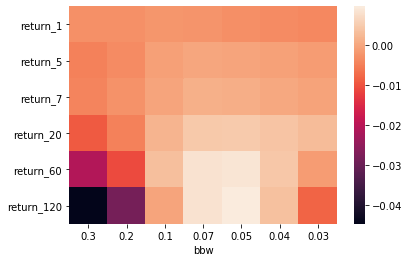

In [143]:
sns.heatmap(perf_df2)

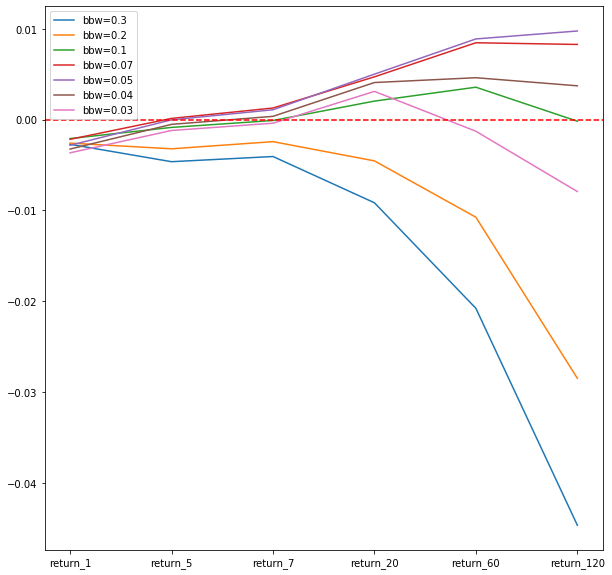

In [144]:
plt.figure(figsize=(10,10))
for col in perf_df2.columns:
    plt.plot(perf_df2[col], label='bbw={}'.format(col))
plt.axhline(y=0, color='r', linestyle='--')
plt.legend()

In [145]:
perf_df

,bbw,prob,return_1,return_120,return_20,return_5,return_60,return_7
0,0.30,0.048145,-0.002724,-0.044638,-0.009156,-0.004639,-0.020774,-0.004068
1,0.20,0.037307,-0.002593,-0.028470,-0.004548,-0.003219,-0.010748,-0.002431
2,0.10,0.014504,-0.002092,-0.000181,0.002030,-0.000865,0.003559,-0.000104
3,0.07,0.006916,-0.002179,0.008264,0.004700,0.000126,0.008451,0.001269
4,0.05,0.003203,-0.002834,0.009744,0.004995,-0.000032,0.008871,0.001076
5,0.04,0.001944,-0.003247,0.003713,0.004074,-0.000530,0.004604,0.000353
6,0.03,0.001070,-0.003662,-0.007921,0.003100,-0.001203,-0.001288,-0.000404


### 볼린저 밴드폭 = 0.05, 0.07 상황에서 밴드 상단 돌파하면, 3주 가량 이후 예후가 좋음

### 밴드폭이 작을수록 좋은것 같음. 너무 작은 경우 오히려 예후가 안좋은데, 데이터 자체가 너무 적어서 그런듯함